In [2]:
import requests
import pandas as pd
from config import census_api_key
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
#Grab Data From Census fir the years 2015-2021

In [4]:

# Replace 'YOUR_API_KEY' with your actual Census API key
api_key = census_api_key

# Specify the dataset and variables
dataset = 'acs/acs5'  # American Community Survey 5-Year Estimates
get_vars = 'NAME,B01001_001E'  # Variable for total population (B01001_001E)

# California's FIPS code
for_state = '06'

# Years range from 2015 to 2022
years = range(2015, 2022)

# Create an empty list to store the data
data_list = []

for year in years:
    # Make the API request
    base_url = f'https://api.census.gov/data/{year}/{dataset}?get={get_vars}&for=place:*&in=state:{for_state}&key={api_key}'
    response = requests.get(base_url)

    if response.status_code == 200:
        data = response.json()
        # Add retrieved data to the list
        for entry in data[1:]:  # Skip the header row
            city_name = entry[0]
            population = entry[1]
            data_list.append({'City': city_name, 'Population': population, 'Year': year})
    else:
        print(f"Failed to retrieve data for year {year}.")


In [5]:
# Create a DataFrame from the collected data
population_data = pd.DataFrame(data_list)



population_data['City'] = population_data['City'].str.replace(', California', '')
population_data['City'] = population_data['City'].str.replace(' CDP', '')
population_data['City'] = population_data['City'].str.replace(' city', '')
population_data['City'] = population_data['City'].str.replace(' town', '')

population_data = population_data.groupby(['City', 'Year'])['Population'].sum().reset_index()
population_data = population_data.pivot(index='City', columns='Year', values='Population')

# Display the DataFrame
population_data = population_data.reset_index()


population_data = population_data.rename(columns={
    2015: '2015 Population',
    2016: '2016 Population',
    2017: '2017 Population',
    2018: '2018 Population',
    2019: '2019 Population',
    2020: '2020 Population',
    2021: '2021 Population',
})
population_data['2015 Population'] = population_data['2015 Population'].astype(float)
population_data['2016 Population'] = population_data['2016 Population'].astype(float)
population_data['2017 Population'] = population_data['2017 Population'].astype(float)
population_data['2018 Population'] = population_data['2018 Population'].astype(float)
population_data['2019 Population'] = population_data['2019 Population'].astype(float)
population_data['2020 Population'] = population_data['2020 Population'].astype(float)
population_data['2021 Population'] = population_data['2021 Population'].astype(float)
population_data = population_data.drop(index=174) #huge amount of population 1047255736.0, possibly an error Burbank City
population_data = population_data.drop(index=981) #huge amount of population 779732295.0, possibly an error Mountain View
population_data = population_data.drop(index=446) #huge amount of population 558124418.0, possibly an error El Cerrito
population_data = population_data.drop(index=817) #huge amount of population 180388467.0, possibly an error Live Oak
population_data = population_data.drop(index=583) #huge amount of population 168694347.0, possibly an error Greenfield
population_data = population_data.drop(index=1081) #huge amount of population 26289170.0, possibly an error Paradise
population_data = population_data.drop(index=1221) #huge amount of population 8161820.0, possibly an error Paradise
population_data

Year,City,2015 Population,2016 Population,2017 Population,2018 Population,2019 Population,2020 Population,2021 Population
0,Acalanes Ridge,1139.0,1000.0,894.0,889.0,1134.0,875.0,1074.0
1,Acampo,787.0,466.0,520.0,294.0,204.0,261.0,263.0
2,Acton,7058.0,7170.0,7278.0,7185.0,7232.0,7054.0,6809.0
3,Adelanto,32059.0,32311.0,32867.0,33416.0,33660.0,34238.0,37229.0
4,Adin,173.0,155.0,206.0,201.0,171.0,209.0,171.0
...,...,...,...,...,...,...,...,...
1611,Yreka,7635.0,7598.0,7571.0,7551.0,7562.0,7589.0,7807.0
1612,Yuba City,66038.0,66147.0,66229.0,66388.0,66516.0,66660.0,69540.0
1613,Yucaipa,52739.0,52886.0,53151.0,53264.0,53416.0,54358.0,54312.0
1614,Yucca Valley,21258.0,21362.0,21483.0,21543.0,21622.0,21701.0,21663.0


In [6]:
#population_data['2015 Population'].max()

In [7]:
#test = population_data[population_data['2015 Population'] == 3900794.0]
#test

In [8]:
#Grab data from zillow.csv

In [9]:
zillow_csv = Path("csv_data/clear_ca_sfh1.csv")

In [10]:
zillow_df = pd.read_csv(zillow_csv)
zillow_df = zillow_df.rename(columns={
    '2015': '2015 Price',
    '2016': '2016 Price',
    '2017': '2017 Price',
    '2018': '2018 Price',
    '2019': '2019 Price',
    '2020': '2020 Price',
    '2021': '2021 Price',
})

In [11]:
merge_df = population_data.merge(zillow_df, on='City')
merge_df

,City,2015 Population,2016 Population,2017 Population,2018 Population,2019 Population,2020 Population,2021 Population,2015 Price,2016 Price,2017 Price,2018 Price,2019 Price,2020 Price,2021 Price
0,Acampo,787.0,466.0,520.0,294.0,204.0,261.0,263.0,411290.3,457113.1,499479.8,549449.1,576265.3,577935.7,706673.6
1,Acton,7058.0,7170.0,7278.0,7185.0,7232.0,7054.0,6809.0,429758.9,449873.7,483729.3,536849.0,565247.3,591931.2,698957.6
2,Adelanto,32059.0,32311.0,32867.0,33416.0,33660.0,34238.0,37229.0,151547.4,163231.4,185646.1,215282.2,229858.4,245152.2,300593.3
3,Adin,173.0,155.0,206.0,201.0,171.0,209.0,171.0,151136.3,163947.3,175406.9,186325.1,191057.7,193622.4,229474.8
4,Agoura Hills,20697.0,20689.0,20736.0,20636.0,20533.0,20269.0,20362.0,726644.3,729300.6,782420.1,849757.7,857486.5,897807.2,1046212.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,Yountville,2985.0,2991.0,2978.0,2982.0,2987.0,3001.0,3351.0,867632.5,930751.6,985898.6,1040493.4,1078248.0,1120945.9,1311820.5
803,Yreka,7635.0,7598.0,7571.0,7551.0,7562.0,7589.0,7807.0,147052.4,155893.3,163423.5,174930.9,190187.6,198080.2,233822.1
804,Yuba City,66038.0,66147.0,66229.0,66388.0,66516.0,66660.0,69540.0,225099.8,243232.4,270577.0,295807.7,310524.3,333738.0,393197.7
805,Yucaipa,52739.0,52886.0,53151.0,53264.0,53416.0,54358.0,54312.0,286070.9,302006.7,332697.6,369420.6,376584.5,397064.1,463536.9


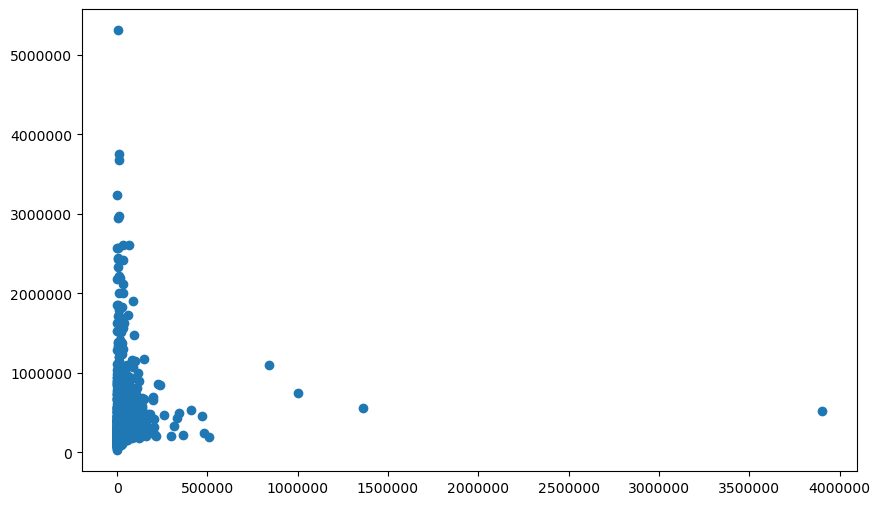

In [12]:
x_data = merge_df['2015 Population']
y_data = merge_df['2015 Price']

plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data)
plt.ticklabel_format(style='plain', axis='both')
plt.show()

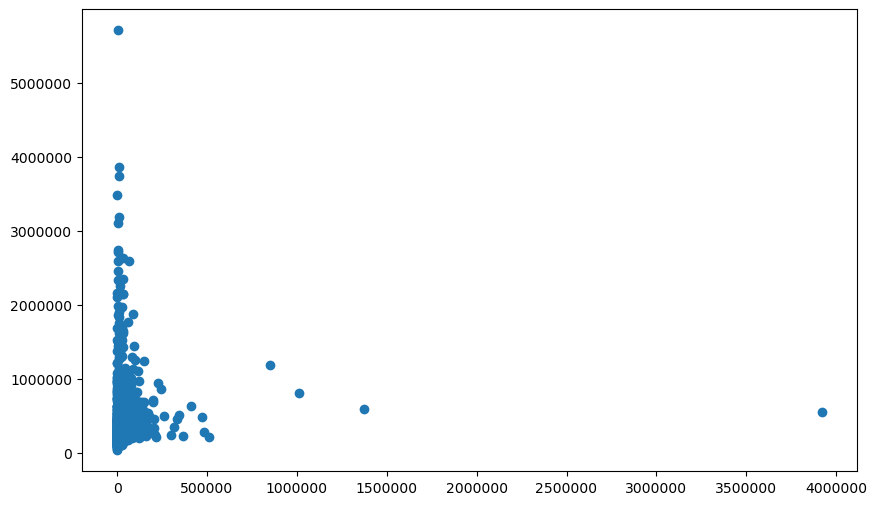

In [13]:
x_data = merge_df['2016 Population']
y_data = merge_df['2016 Price']

plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data)
plt.ticklabel_format(style='plain', axis='both')
plt.show()

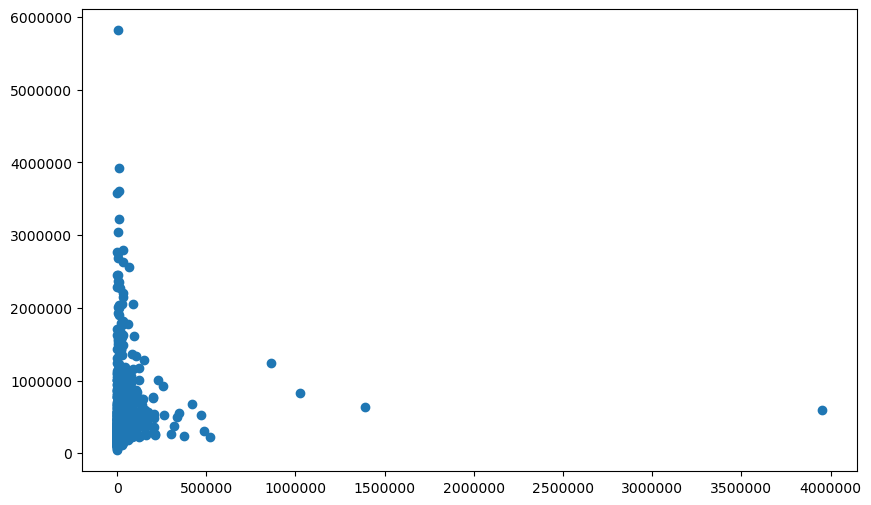

In [14]:
x_data = merge_df['2017 Population']
y_data = merge_df['2017 Price']

plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data)
plt.ticklabel_format(style='plain', axis='both')
plt.show()

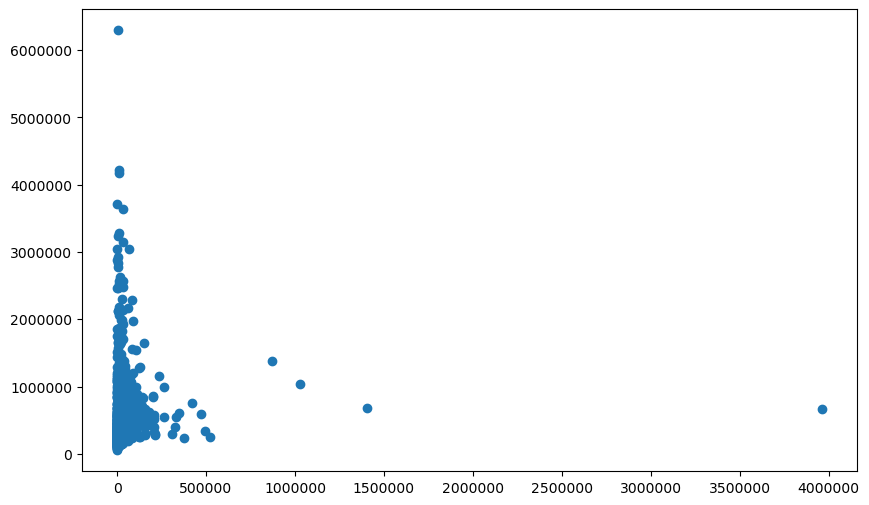

In [15]:
x_data = merge_df['2018 Population']
y_data = merge_df['2018 Price']

plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data)
plt.ticklabel_format(style='plain', axis='both')
plt.show()

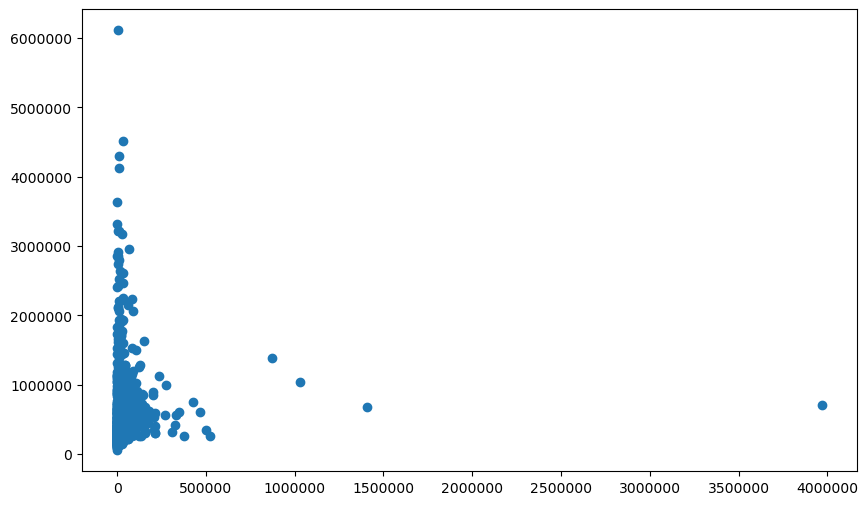

In [16]:
x_data = merge_df['2019 Population']
y_data = merge_df['2019 Price']

plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data)
plt.ticklabel_format(style='plain', axis='both')
plt.show()

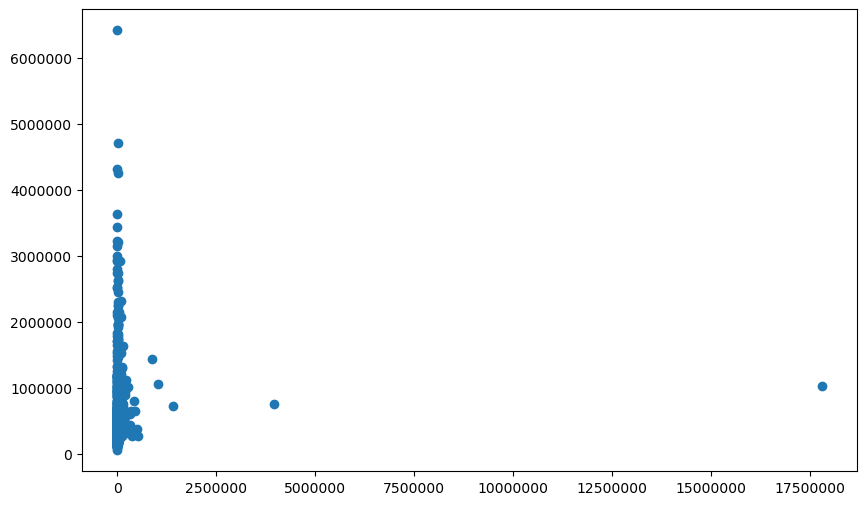

In [17]:
x_data = merge_df['2020 Population']
y_data = merge_df['2020 Price']

plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data)
plt.ticklabel_format(style='plain', axis='both')
plt.show()

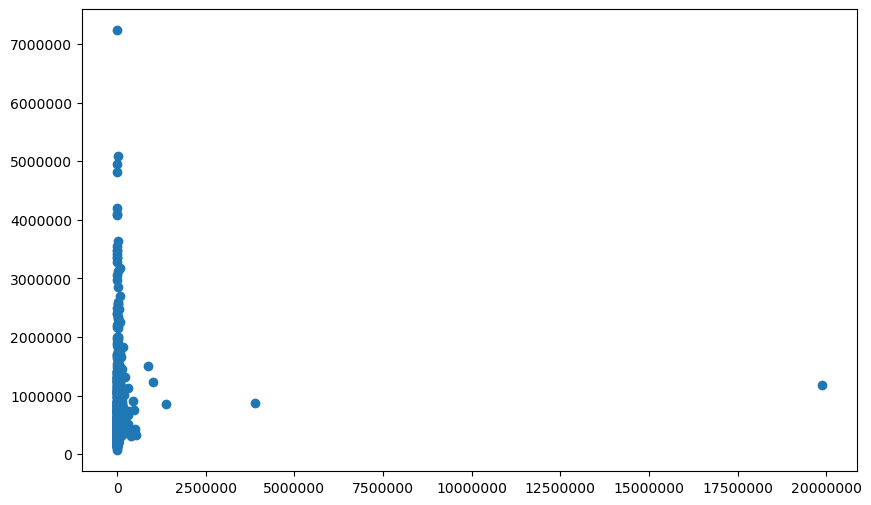

In [18]:
x_data = merge_df['2021 Population']
y_data = merge_df['2021 Price']

plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data)
plt.ticklabel_format(style='plain', axis='both')
plt.show()

KeyError: '2022 Population'